# Micro-contributions and active editors

We're interested in understanding to what extent users who make micro-contributions are also active editors, and to what extent these users are classified as "new active editors" (meaning their account on the wiki was created in the same month).

We currently have three types of micro-contributions:

1. Description edits on Wikidata.
2. Caption edits on Commons.
3. Depicts edits on Commons.

So, for Wikidata and Commons, we would like to know how many active editors those wikis had over time, how many of them were making micro-contributions, how many of them made enough micro-contributions to qualify as an active editor, and lastly how many of the latter two groups of where new accounts in a given month.

The analyses in this notebook started in August 2019, focusing on the first half of 2019. A second round of analysis was done in early March 2020, looking at the second half of 2019 as well as January 2020. It has not been rewritten/reorganized to make complete sense as a single storyline. Hopefully the notes around data/graphs enables the findings to be comprehensible.

In [1]:
import datetime as dt

import pandas as pd
import numpy as np

from wmfdata import spark, mariadb

from growth import utils

You are using wmfdata 0.1.0 (latest).

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2)
library(data.table)

First, let's grab user IDs of all users who are labelled as active editors in a given month for the given wikis and date ranges associated with those wikis. Because we want something to compare with, we'll grab data for a year prior to the micro-contributions being released.

In [4]:
## based on
## from https://github.com/wikimedia-research/Editing-movement-metrics/blob/master/queries/active_editors.sql
## Currently working around duplicate editor data in June 2019.
active_editors_query = '''
WITH editor_data AS (
  SELECT
    CAST(month AS date) AS log_month,
    user_id,
    user_name,
    SUM(content_edits) AS content_edits,
    MAX(bot_by_group) AS bot_by_group,
    CAST(TRUNC(MIN(user_registration), "MONTH") AS date) AS registration_month
  FROM (
      SELECT DISTINCT month, user_id, user_name, content_edits, bot_by_group, user_registration
      FROM neilpquinn.editor_month
      WHERE wiki = "{wiki}"
      AND month BETWEEN "{start_ts}" AND "{end_ts}"
      AND user_id != 0
  ) AS e
  GROUP BY month, user_id, user_name
)
SELECT log_month, user_id, content_edits,
       CAST(registration_month = log_month AS int) AS is_new_active
FROM editor_data
WHERE
  content_edits >= 5
  AND NOT bot_by_group
  AND user_name NOT REGEXP "bot\\b"
'''

In [5]:
wikidata_actives = spark.run(
    active_editors_query.format(
        wiki = "wikidatawiki",
        start_ts = "2016-01-01",
        end_ts = "2020-02-01")
)

In [6]:
commons_actives = spark.run(
    active_editors_query.format(
        wiki = "commonswiki",
        start_ts = "2018-01-01",
        end_ts = "2020-02-01")
)

Next, we grab similar data (user ID, month, number of edits) for all micro-contributions made to the given wikis.

In [7]:
## we won't have to worry about distinguishing between bots and regular users in this case,
## because we'll filter those out when we join with the previous datasets.
wd_mce_query = '''
SELECT DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month, event_user_id, count(*) AS num_micros
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
  AND wiki_db = "wikidatawiki"
  AND event_timestamp >= "{start_ts}"
  AND event_timestamp < "{end_ts}"
  AND event_entity = "revision"
  AND event_type = "create"
  AND array_contains(revision_tags, "mobile app edit") = TRUE
  AND event_user_id IS NOT NULL -- exclude if revdeleted
GROUP BY DATE_FORMAT(event_timestamp, "yyyy-MM-01"), event_user_id
'''

**NOTE:** The query for micro-contributions to Commons below was updated in March 2020 to include additional types of contributions, as identified in https://github.com/wikimedia-research/SDC-metrics-2019/blob/master/T231952-part-1b.ipynb

In [8]:
## similar query for commons
commons_mce_query = '''
SELECT DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month, event_user_id, count(*) AS num_micros
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
  AND wiki_db = "commonswiki"
  AND event_timestamp >= "{start_ts}"
  AND event_timestamp < "{end_ts}"
  AND event_entity = "revision"
  AND event_type = "create"
  AND (
    event_comment REGEXP "^...wbsetlabel-(add|set|remove):"
    OR event_comment REGEXP "^...wbsetclaim-(create|update):"
    OR event_comment REGEXP "^...wbcreateclaim-create:"
    OR event_comment REGEXP "^...wbeditentity-(update|update-languages):"
    OR event_comment REGEXP "^...wbremoveclaims-(update|remove):"
    OR event_comment REGEXP "^...wbsetqualifier-add:"
  )
  AND event_user_id IS NOT NULL -- exclude if revdeleted
GROUP BY DATE_FORMAT(event_timestamp, "yyyy-MM-01"), event_user_id
'''

In [9]:
wikidata_mces = spark.run(   
    wd_mce_query.format(
        snapshot = "2020-02",
        start_ts = "2016-01-01",
        end_ts = "2020-02-01")
)

In [10]:
commons_mces = spark.run(   
    commons_mce_query.format(
        snapshot = "2020-02",
        start_ts = "2016-01-01",
        end_ts = "2020-02-01")
)

Now, let's join the two datasets (using a left join), fill all missing data with zeroes, and start making some graphs.

In [11]:
## turn log month into dates

wikidata_actives['log_month'] = pd.to_datetime(wikidata_actives['log_month'])
wikidata_mces['log_month'] = pd.to_datetime(wikidata_mces['log_month'])
commons_actives['log_month'] = pd.to_datetime(commons_actives['log_month'])
commons_mces['log_month'] = pd.to_datetime(commons_mces['log_month'])

In [12]:
wd_actives_full = wikidata_actives.merge(wikidata_mces,
                                         how = 'left', left_on = ['log_month', 'user_id'],
                                         right_on = ['log_month', 'event_user_id']).fillna(0)

In [13]:
commons_actives_full = commons_actives.merge(commons_mces,
                                             how = 'left', left_on = ['log_month', 'user_id'],
                                             right_on = ['log_month', 'event_user_id']).fillna(0)

In [14]:
## Calculate the number of content contributions with micro-contributions removed

wd_actives_full['non_micro_edits'] = wd_actives_full.content_edits - wd_actives_full.num_micros
commons_actives_full['non_micro_edits'] = commons_actives_full.content_edits - commons_actives_full.num_micros

In [15]:
def get_active_stats(df, start_date, end_date):
    '''
    For the given `pandas.DataFrame` `df` containing information on number of content edits,
    account age status (new or existing user), and number of micro-contribution edits made,
    calculate for each month between `start_date` and `end_date` the following stats:
    
    * Number of active editors (all users in that month, our dataset only includes active editors)
    * Number of active editors who made at least 1 micro-contribution
    * Number of active editors who made 5 or more micro-contributions (meaning they made enough
      to quality as an active editor by micro-contributions alone)
    * Number of active editors who made at least 1 micro-contribution who were new that month
    * Number of active editors who made 5 or more micr-contributions who were new that month.
    '''

    ## Date range from start to end:
    date_range = pd.date_range(start_date, end_date, freq = "MS")

    ## Long-form data frame with month, type of editor (active, active w/1+ mce, etc), and number of editors
    res_df = pd.DataFrame(columns = ['log_month', 'editor_type', 'n'])
    
    for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
        ## All users are active because we filtered out non-active ones
        n_active = len(df.loc[(df['log_month'] >= date_range[month_idx]) &
                              (df['log_month'] < date_range[month_idx + 1])])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active', n_active]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Actives who made at least one micro-contribution
        n_mces = len(df.loc[(df['log_month'] >= date_range[month_idx]) &
                              (df['log_month'] < date_range[month_idx + 1]) &
                              (df['num_micros'] > 0)])

        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], '1+ micro', n_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Actives who made at least five micro-contributions
        n_active_mces = len(df.loc[(df['log_month'] >= date_range[month_idx]) &
                                   (df['log_month'] < date_range[month_idx + 1]) &
                                   (df['num_micros'] >= 5)])

        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], '5+ micro', n_active_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## New active editors
        n_new_active = len(df.loc[(df['log_month'] >= date_range[month_idx]) &
                                  (df['log_month'] < date_range[month_idx + 1]) &
                                  (df['is_new_active'] == 1)])

        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active', n_new_active]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## New active editors w/1+ micro-contributions
        n_new_mces = len(df.loc[(df['log_month'] >= date_range[month_idx]) &
                                (df['log_month'] < date_range[month_idx + 1]) &
                                (df['is_new_active'] == 1) &
                                (df['num_micros'] > 0)])

        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new 1+ micro', n_new_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## New active editors w/5+ micro-contributions
        n_new_active_mces = len(df.loc[(df['log_month'] >= date_range[month_idx]) &
                                       (df['log_month'] < date_range[month_idx + 1]) &
                                       (df['is_new_active'] == 1) &
                                       (df['num_micros'] >= 5)])

        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new 5+ micro', n_new_active_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
    return(res_df)    

In [16]:
def get_corrected_stats(df, start_date, end_date):
    '''
    For the given `pandas.DataFrame` `df` containing information on number of content edits,
    account age status (new or existing user), and number of micro-contribution edits made,
    calculate for each month between `start_date` and `end_date` the following stats:
    
    * Number of active editors with micro-contributions removed
    * Number of active editors who only made micro-contributions
    * Number of new active editors with micro-contributions removed
    * Number of new active editors who only made micro-contributions
    '''

    ## Date range from start to end:
    date_range = pd.date_range(start_date, end_date, freq = "MS")

    ## Long-form data frame with month, type of editor (active, active w/1+ mce, etc), and number of editors
    res_df = pd.DataFrame(columns = ['log_month', 'editor_type', 'n'])
    
    for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
        ## Number of active editors with micro-contributions removed
        n_active_wo_mces = len(df.loc[(df['log_month'] >= date_range[month_idx]) &
                                       (df['log_month'] < date_range[month_idx + 1]) &
                                       (df['non_micro_edits'] >= 5)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active w/o micro', n_active_wo_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of active editors who only made micro-contributions
        n_active_only_mces = len(df.loc[(df['log_month'] >= date_range[month_idx]) &
                                        (df['log_month'] < date_range[month_idx + 1]) &
                                        (df['content_edits'] == df.num_micros)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active only micro', n_active_only_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of new active editors with micro-contributions removed
        n_new_active_wo_mces = len(df.loc[(df['log_month'] >= date_range[month_idx]) &
                                       (df['log_month'] < date_range[month_idx + 1]) &
                                       (df['is_new_active'] == 1) &
                                       (df['non_micro_edits'] >= 5)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active w/o micro', n_new_active_wo_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    
        ##Number of new active editors who only made micro-contributions
        n_active_only_mces = len(df.loc[(df['log_month'] >= date_range[month_idx]) &
                                        (df['log_month'] < date_range[month_idx + 1]) &
                                        (df['is_new_active'] == 1) &
                                        (df['content_edits'] == df.num_micros)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active only micro', n_active_only_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    return(res_df)    

In [17]:
wd_active_stats = get_active_stats(wd_actives_full, '2016-01-01', '2020-02-01')

In [18]:
commons_active_stats = get_active_stats(commons_actives_full, '2018-01-01', '2020-02-01')

In [19]:
wd_corrected_stats = get_corrected_stats(wd_actives_full, '2016-01-01', '2020-02-01')

In [20]:
commons_corrected_stats = get_corrected_stats(commons_actives_full, '2018-01-01', '2020-02-01')

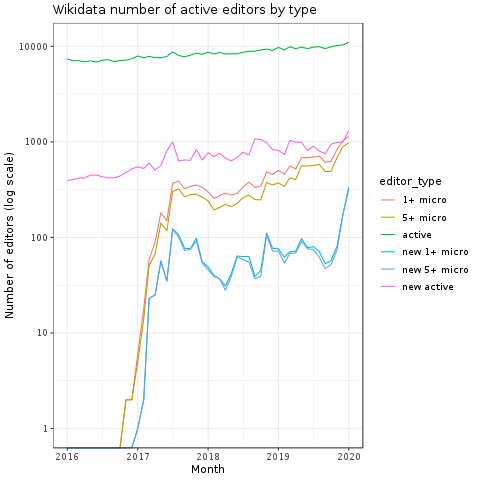

In [28]:
%%R -i wd_active_stats

wd_active_stats$log_month = as.Date(wd_active_stats$log_month)

ggplot(wd_active_stats,
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_log10("Number of editors (log scale)") +
scale_x_date("Month") +
ggtitle("Wikidata number of active editors by type") +
geom_line()

What does this graph tell us? Overall, we see that the number of active editors on Wikidata is fairly stable, but slowly increasing over time, reaching around 10k in more recent months. We can also see that there is a slowly increasing trend in the number of new active editors on Wikidata, and that it passed 1k in both the end of 2018 and early 2019.

What we can also see is that the number of new active editors who made microcontributions is not large, it generally ends up being about 100. Those who do make microcontributions tend to make enough of those alone to become an active editor. We can also see that it is not clear that the trend is an increase in these editors.

Lastly, we see that there an increase in the number of active editors over time who make micro-contributions. Because we don't see an increase in the trend of new editors, this means that these are users who have been around. I think this motivates looking into whether users who make micro-contributions are more likely to be retained.

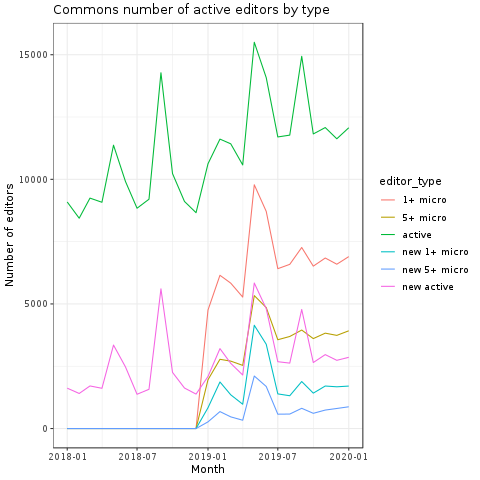

In [29]:
%%R -i commons_active_stats

commons_active_stats$log_month = as.Date(commons_active_stats$log_month)

ggplot(commons_active_stats,
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_continuous("Number of editors") +
scale_x_date("Month") +
ggtitle("Commons number of active editors by type") +
geom_line()

What does this graph tell us? First, we can see the overall trends of increases in May/June (Wiki Loves Earth) and September (Wiki Loves Monuments) that we expect, the former for both 2018 and 2019. We can also see that these increases correlate with increases in new active editors, meaning that we see a fair amount of new users coming to Commons that make at least 5 edits.

Secondly, we see the introduction of micro-contributions in January of this year. We see that about half of the active editors make a micro-contribution in January through April, while in May and June the proportion is about two thirds. Similarly, we see new editors also come in and contribute to these numbers. Quite a number of them make at least one micro-contribution, and many of them make at least five.

In [30]:
## Looking at the numbers to get a sense of proportions:
commons_active_stats.loc[commons_active_stats.log_month >= '2019-01-01']

,log_month,editor_type,n
0,2019-01-01,active,10624
0,2019-01-01,1+ micro,4756
0,2019-01-01,5+ micro,1958
0,2019-01-01,new active,2088
0,2019-01-01,new 1+ micro,834
...,...,...,...
0,2020-01-01,1+ micro,6899
0,2020-01-01,5+ micro,3922
0,2020-01-01,new active,2859
0,2020-01-01,new 1+ micro,1704


Let's get a sense of how the number of active contributors is affected by micro-contributions by taking them out, and also looking at number of active editors who only made micro-contributions.

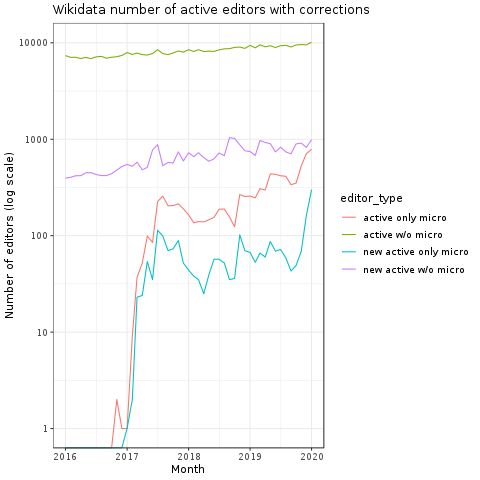

In [31]:
%%R -i wd_corrected_stats

wd_corrected_stats$log_month = as.Date(wd_corrected_stats$log_month)

ggplot(wd_corrected_stats,
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_log10("Number of editors (log scale)") +
scale_x_date("Month") +
ggtitle("Wikidata number of active editors with corrections") +
geom_line()

R[write to console]: Saving 6.67 x 6.67 in image



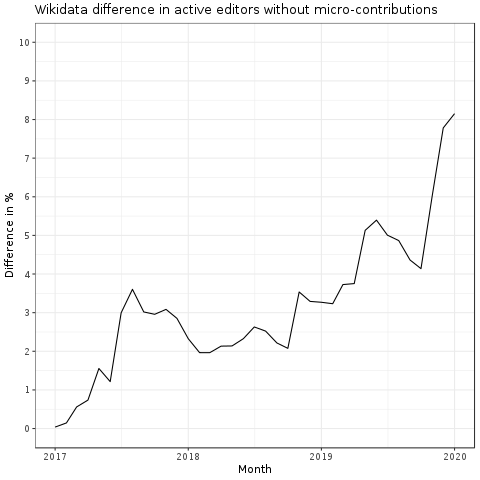

In [32]:
%%R -i wd_active_stats,wd_corrected_stats

## Merge the two and calculate a diff between active with and without micro-contributions

wd_active_stats = data.table(wd_active_stats)
wd_corrected_stats = data.table(wd_corrected_stats)

wd_both = merge(wd_active_stats[editor_type == 'active', list(log_month, n_active = n)],
                wd_corrected_stats[editor_type == 'active w/o micro', list(log_month, n_active_nomicro = n)],
                by = 'log_month')
wd_both[, n_diff := n_active - n_active_nomicro]
wd_both[, prop_diff := 100 * n_diff / n_active]
wd_both[, log_month := as.Date(log_month)]

g = ggplot(wd_both[log_month >= as.Date('2017-01-01')],
       aes(x = log_month, y = prop_diff)) +
theme_bw() +
scale_y_continuous("Difference in %", lim = c(0, 10), breaks = c(0:10)) +
scale_x_date("Month") +
ggtitle("Wikidata difference in active editors without micro-contributions") +
geom_line()

ggsave(g, file = "graphs/wikidata_diff_active_wo_micro.png")
g

So, for Wikidata we see that the number of new active editors who solely make micro-contributions is fairly stable over time. However, we find an increasing influence of micro-contributions on the overall number of active editors, particularly in the first half of 2019. This is also seen in the other graph above, where the number of active editors who are solely making micro-contributions is increasing over time, particularly in the past six months.

Below is an updated graph showing the proportion of active editors in Wikidata that only make contributions through the mobile apps. As we can see, this proportion grew strongly in late 2019 and early 2020.

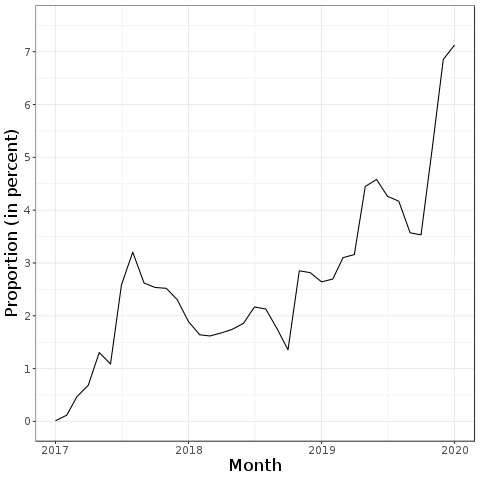

In [266]:
%%R -i wd_active_stats,wd_corrected_stats

## Merge the two and calculate the proportion of editors who _only_ make micro-contributions,
## then plot that.

## NOTE: remember that if the proportion is outside the limit set on the Y axis,
## no data points will be plotted. So you might have to modify that value.

wd_active_stats = data.table(wd_active_stats)
wd_corrected_stats = data.table(wd_corrected_stats)

wd_both = merge(wd_active_stats[editor_type == 'active', list(log_month, n_active = n)],
                wd_corrected_stats[editor_type == 'active only micro', list(log_month, n_active_micro = n)],
                by = 'log_month')
wd_both[, prop_micro := 100 * n_active_micro / n_active]
wd_both[, log_month := as.Date(log_month)]

g = ggplot(wd_both[log_month >= as.Date('2017-01-01')],
           aes(x = log_month, y = prop_micro)) +
    theme_bw() +
    theme(axis.title.x = element_text(size = rel(1.5)),
          axis.text.x = element_text(size = rel(1.25)),
          axis.title.y = element_text(size = rel(1.5)),
          axis.text.y = element_text(size = rel(1.25))) +
    scale_y_continuous("Proportion (in percent)", lim = c(0, 7.5), breaks = c(0:10)) +
    scale_x_date("Month", date_breaks = "1 year", date_labels = "%Y") +
    geom_line()

ggsave(plot = g, file = "graphs/wikidata_prop_active_only_microcontributions_2020.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

In [126]:
%%R

wd_both[log_month >= '2019-01-01']

     log_month n_active n_active_micro prop_micro
 1: 2019-01-01     9728            257   2.641859
 2: 2019-02-01     9160            247   2.696507
 3: 2019-03-01     9900            307   3.101010
 4: 2019-04-01     9434            298   3.158787
 5: 2019-05-01     9822            437   4.449196
 6: 2019-06-01     9452            433   4.581041
 7: 2019-07-01     9809            418   4.261393
 8: 2019-08-01     9906            413   4.169190
 9: 2019-09-01     9466            338   3.570674
10: 2019-10-01     9906            350   3.533212
11: 2019-11-01    10205            529   5.183733
12: 2019-12-01    10331            708   6.853160
13: 2020-01-01    11028            786   7.127312


## Micro-contributions edit and revert rate

Shay pointed out that a new version of the Android app was released on Nov 26, and this version did not contain the same guardrails around Suggested Edits as previously (needed 5 non-reverted edits to get access).

How did that affect average number of edits for new active editors making micro-contributions, and also the revert rate? Let's study this for the FY1920.

I'll start by looking at *all* their edits in the month they were identified as a new active editor. Secondary, I might also want to look at this for their first $k$ edits, for some value of $k$. (Maybe just the first few, such as 10 or 25, 50?)

In [75]:
edit_revert_query = '''
SELECT DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month, event_user_id,
       count(*) AS num_micros,
       SUM(IF(revision_is_identity_reverted = true
              AND revision_seconds_to_identity_revert < 60*60*48, 1, 0)) AS num_reverted
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
  AND wiki_db = "wikidatawiki"
  AND event_timestamp >= "{start_ts}"
  AND event_timestamp < "{end_ts}"
  AND event_entity = "revision"
  AND event_type = "create"
  AND array_contains(revision_tags, "mobile app edit") = TRUE
  AND event_user_id IS NOT NULL -- exclude if revdeleted
GROUP BY DATE_FORMAT(event_timestamp, "yyyy-MM-01"), event_user_id
'''

In [79]:
edit_revert_rates = spark.run(edit_revert_query.format(
        snapshot = "2020-02",
        start_ts = "2019-07-01",
        end_ts = "2020-02-01"))

In [82]:
edit_revert_rates['log_month'] = pd.to_datetime(edit_revert_rates['log_month'])

In [86]:
## Merge with active users

edit_reverts_full = (wikidata_actives.loc[wikidata_actives['log_month'] >= '2019-07-01']
                     .merge(edit_revert_rates,
                            how = 'left', left_on = ['log_month', 'user_id'],
                            right_on = ['log_month', 'event_user_id'])).fillna(0)

In [88]:
## Calculate revert rate
edit_reverts_full['revert_rate'] = edit_reverts_full['num_reverted'] / edit_reverts_full['num_micros']

In [ ]:
edit_reverts_full.loc[edit_reverts_full['content_edits'] == edit_reverts_full['num_micros']]

In [178]:
## Aggregate across month, split by new/returning, and calculate average edit rate and revert rate
## We're only concerned about users who only made micro-contributions.

edit_reverts_agg = (edit_reverts_full.loc[edit_reverts_full['content_edits'] == edit_reverts_full['num_micros']]
                    .groupby(['log_month', 'is_new_active'])
                    .agg({'user_id' : 'count', 'num_micros' : 'mean', 'num_reverted' : 'mean',
                          'revert_rate' : 'mean'}).reset_index())

In [ ]:
edit_reverts_agg

Calculate mean, median, and IQR for the revert rate and plot those? Thing is, the size of the distribution has changed so much, so the mean no longer makes as much sense. Or does it?

Yeah, I want some error bars on these measurements or something, to show what the spread is.

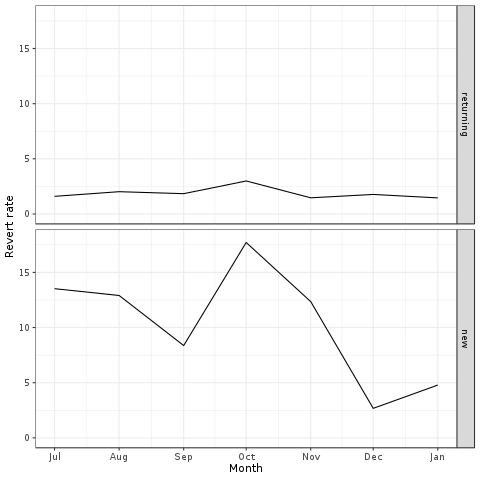

In [166]:
%%R -i edit_reverts_agg

edit_reverts_agg = data.table(edit_reverts_agg)
edit_reverts_agg[, log_month := as.Date(log_month)]
edit_reverts_agg[, log_month_name := ordered(
    strftime(log_month, "%b"),
    c("Jul", "Aug", "Sep", "Oct", "Nov", "Dec",
      "Jan", "Feb", "Mar", "Apr", "May", "Jun"))]

edit_reverts_agg[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]

g = ggplot(edit_reverts_agg[log_month < '2020-02-01'],
       aes(x = log_month, y = 100 * revert_rate)) +
theme_bw() +
scale_y_continuous("Revert rate", limits = c(0, 18)) +
scale_x_date("Month", date_breaks = "1 month", date_labels = "%b") +
facet_grid(active_type ~ .) +
geom_line()

#ggsave(plot = g, file = "graphs/commons_active_editors_micros_1920_split.png",
#       width = 8, height = 6, units = "in", dpi = "retina")
g

In [121]:
%%R
## From http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_(ggplot2)/

## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

In [168]:
%%R -i edit_reverts_full

edit_reverts_full$active_type = factor(edit_reverts_full$is_new_active,
                                        levels = c(0, 1), labels = c("returning", "new"))
edits_reverts_summ = summarySE(
    subset(edit_reverts_full, content_edits == num_micros),
    measurevar = "revert_rate", groupvars  = c("log_month", "active_type"))

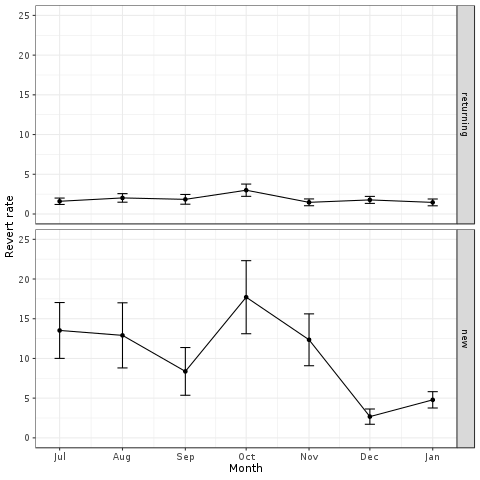

In [172]:
%%R

edits_reverts_summ$log_month = as.Date(edits_reverts_summ$log_month)

ggplot(edits_reverts_summ, aes(x = log_month, y = 100 * revert_rate)) + 
    theme_bw() +
    scale_y_continuous("Revert rate", limits = c (0, 25)) +
    scale_x_date("Month", date_breaks = "1 month", date_labels = "%b") +
    facet_grid(active_type ~ .) +
    geom_errorbar(aes(ymin = 100 * (revert_rate - se), ymax = 100 * (revert_rate + se)), width = 5) +
    geom_line() +
    geom_point()

What's the median and IQR for revert_rate?

In [236]:
## Aggregate across month, split by new/returning, and calculate average edit rate and revert rate

(edit_reverts_full.loc[edit_reverts_full['content_edits'] == edit_reverts_full['num_micros']]
 .groupby(['log_month', 'is_new_active'])['num_micros', 'revert_rate']
 .quantile(0.5))

num_micros  revert_rate
log_month  is_new_active                         
2019-07-01 0.0                  12.0          0.0
           1.0                  10.5          0.0
2019-08-01 0.0                  13.0          0.0
           1.0                   8.0          0.0
2019-09-01 0.0                  11.0          0.0
           1.0                   8.0          0.0
2019-10-01 0.0                  10.0          0.0
           1.0                  10.0          0.0
2019-11-01 0.0                  12.0          0.0
           1.0                  10.0          0.0
2019-12-01 0.0                  12.0          0.0
           1.0                  12.0          0.0
2020-01-01 0.0                  12.0          0.0
           1.0                  13.0          0.0

One of the challenges here is the size of the population. The number of users above the 90th percentile before November is like 10 users. In January, they were 30. The top quartile was maybe 25 users, then now they're 75. While I wouldn't be surprised if that's not really many on the scale of Wikidata on the whole, it's a meaningful difference.

Also, this is a key difference between this analysis and Shay's. They're looking at *all* new users from Nov 26 onwards, we're only looking at those who made at least 5+ edits, and where all of those edits were app edits. So any user who made <5 edits, and perhaps got reverted, are not part of my analysis.

## Removing micro-contribution edits on Commons

Let's make the same investigation for Commons as we did initially for Wikidata, taking out the micro-contributions.

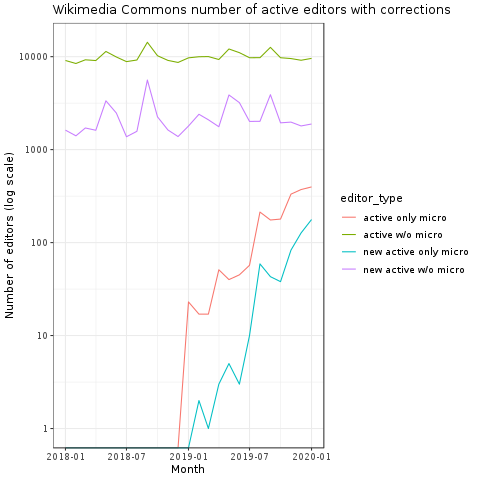

In [155]:
%%R -i commons_corrected_stats

commons_corrected_stats$log_month = as.Date(commons_corrected_stats$log_month)

ggplot(commons_corrected_stats,
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_log10("Number of editors (log scale)") +
scale_x_date("Month") +
ggtitle("Wikimedia Commons number of active editors with corrections") +
geom_line()

In [156]:
commons_corrected_stats.tail(10)

,log_month,editor_type,n
0,2019-11-01,new active w/o micro,1977
0,2019-11-01,new active only micro,83
0,2019-12-01,active w/o micro,9144
0,2019-12-01,active only micro,372
0,2019-12-01,new active w/o micro,1797
0,2019-12-01,new active only micro,127
0,2020-01-01,active w/o micro,9579
0,2020-01-01,active only micro,397
0,2020-01-01,new active w/o micro,1886
0,2020-01-01,new active only micro,177


In [239]:
## what's the percentage?
100 * 42 / 10870

0.38638454461821525

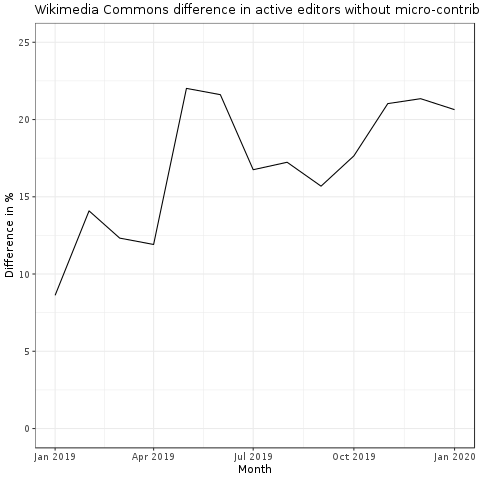

In [157]:
%%R -i commons_active_stats,commons_corrected_stats

## Merge the two and calculate a diff between active with and without micro-contributions

commons_active_stats = data.table(commons_active_stats)
commons_corrected_stats = data.table(commons_corrected_stats)

commons_both = merge(commons_active_stats[editor_type == 'active', list(log_month, n_active = n)],
                commons_corrected_stats[editor_type == 'active w/o micro', list(log_month, n_active_nomicro = n)],
                by = 'log_month')
commons_both[, n_diff := n_active - n_active_nomicro]
commons_both[, prop_diff := 100 * n_diff / n_active]
commons_both[, log_month := as.Date(log_month)]

ggplot(commons_both[log_month >= as.Date('2019-01-01')],
       aes(x = log_month, y = prop_diff)) +
theme_bw() +
scale_y_continuous("Difference in %", lim = c(0, 25)) +
scale_x_date("Month") +
ggtitle("Wikimedia Commons difference in active editors without micro-contributions") +
geom_line()

What we see on Commons are stark differences compared to what we've previously seen. First, the number of active editors when taking micro-contributions out is fairly stable, around 10,000. The increase in May/June that we've seen before and associated with Wiki Loves Earth goes away. Secondly, we see that micro-contributions are not what active users on Commons do, the number of new users who only make those contributions is very small, and the overall number is also less than 1% of the total.

The second graph tells a very different story, where we see the difference in proportions between active editors depending on whether we count micro-contributions or not. Here, we see that in May and June, the difference is 23% lower if we take those contributions out. We can also see that this proportion was lower before May and June when WLE ran, prior to that the range is 9–15%. That is still a substantial difference, but nowhere as strong as for May and June.

It's also worth noticing that the number of active editors on Wikidata and Commons is roughly comparable in some of these graphs. For example in both of the corrected ones, the number of active editors is around 10,000.

In [161]:
%%R

commons_both

     log_month n_active n_active_nomicro n_diff prop_diff
 1: 2018-01-01     9091             9091      0  0.000000
 2: 2018-02-01     8439             8439      0  0.000000
 3: 2018-03-01     9246             9246      0  0.000000
 4: 2018-04-01     9079             9079      0  0.000000
 5: 2018-05-01    11370            11370      0  0.000000
 6: 2018-06-01     9914             9914      0  0.000000
 7: 2018-07-01     8840             8840      0  0.000000
 8: 2018-08-01     9202             9202      0  0.000000
 9: 2018-09-01    14275            14275      0  0.000000
10: 2018-10-01    10230            10230      0  0.000000
11: 2018-11-01     9112             9112      0  0.000000
12: 2018-12-01     8661             8661      0  0.000000
13: 2019-01-01    10624             9708    916  8.621988
14: 2019-02-01    11613             9977   1636 14.087660
15: 2019-03-01    11424            10016   1408 12.324930
16: 2019-04-01    10577             9317   1260 11.912641
17: 2019-05-01

## Commons – Active micro-contributors

We repeat the analysis we did for Wikidata, but look at users who only make SDC edits.

In [238]:
commons_corrected_stats.head()

,log_month,editor_type,n
0,2018-01-01,active w/o micro,9091
0,2018-01-01,active only micro,0
0,2018-01-01,new active w/o micro,1620
0,2018-01-01,new active only micro,0
0,2018-02-01,active w/o micro,8439


The graph below is a graph of the proportion of active editors on Commons that solely made SDC contributions, similar to the one we previously made for app edits on Wikidata.

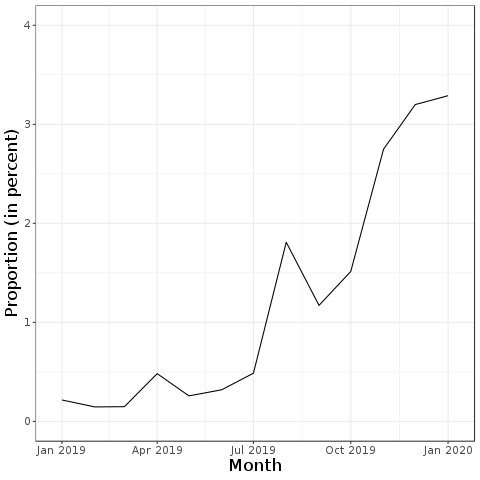

In [264]:
%%R -i commons_active_stats,commons_corrected_stats

## Merge the two and calculate the proportion of editors who _only_ make micro-contributions,
## then plot that.

## NOTE: remember that if the proportion is outside the limit set on the Y axis,
## no data points will be plotted. So you might have to modify that value.

commons_active_stats = data.table(commons_active_stats)
commons_corrected_stats = data.table(commons_corrected_stats)

commons_both = merge(commons_active_stats[editor_type == 'active', list(log_month, n_active = n)],
                commons_corrected_stats[editor_type == 'active only micro', list(log_month, n_active_micro = n)],
                by = 'log_month')
commons_both[, prop_micro := 100 * n_active_micro / n_active]
commons_both[, log_month := as.Date(log_month)]

g = ggplot(commons_both[log_month >= as.Date('2019-01-01')],
           aes(x = log_month, y = prop_micro)) +
    theme_bw() +
    theme(axis.title.x = element_text(size = rel(1.5)),
          axis.text.x = element_text(size = rel(1.25)),
          axis.title.y = element_text(size = rel(1.5)),
          axis.text.y = element_text(size = rel(1.25))) +
    scale_y_continuous("Proportion (in percent)", lim = c(0, 4), breaks = c(0:10)) +
    scale_x_date("Month", breaks = as.Date(c('2019-01-01', '2019-04-01', '2019-07-01',
                                             '2019-10-01', '2020-01-01')),
                 date_labels = "%b %Y", expand = c(0, 25)) +
    geom_line()

ggsave(plot = g, file = "graphs/commons_prop_active_only_microcontributions_2020.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

In [265]:
%%R

commons_both

     log_month n_active n_active_micro prop_micro
 1: 2018-01-01     9091              0  0.0000000
 2: 2018-02-01     8439              0  0.0000000
 3: 2018-03-01     9246              0  0.0000000
 4: 2018-04-01     9079              0  0.0000000
 5: 2018-05-01    11370              0  0.0000000
 6: 2018-06-01     9914              0  0.0000000
 7: 2018-07-01     8840              0  0.0000000
 8: 2018-08-01     9202              0  0.0000000
 9: 2018-09-01    14275              0  0.0000000
10: 2018-10-01    10230              0  0.0000000
11: 2018-11-01     9112              0  0.0000000
12: 2018-12-01     8661              0  0.0000000
13: 2019-01-01    10624             23  0.2164910
14: 2019-02-01    11613             17  0.1463877
15: 2019-03-01    11424             17  0.1488095
16: 2019-04-01    10577             51  0.4821783
17: 2019-05-01    15499             40  0.2580812
18: 2019-06-01    14078             45  0.3196477
19: 2019-07-01    11700             57  0.4871795


## Impact of WLE and WLP and WLM

The impact of Wiki Loves Earth and Wiki Loves Pride and Wiki Loves Monuments:

1. What is the number of active editors if we remove all WLE/WLP activity?
2. What is the number of active editors who uploaded WLE/WLP contributions?

To answer this, we'll use the WLE and WLP categories on Commons to identify pages within the scope of those campaigns. Because the focus of the campaigns is the multimedia content uploaded, we'll restrict the scope to the File namespace. This means that coordinating activity around these (e.g. discussions on talk pages, or updating of campaign pages) will count as "normal" edits.

For Wiki Loves Earth, we will use any files in the "Wiki Loves Earth 2019" category, as well as the category for all images named "Images from Wiki Loves Earth 2019". For Wiki Loves Pride, we'll use all images in the category "Wiki Loves Pride 2019".

As we did for micro-contributions, we'll count monthly edits by users to these files and label them as `earth_edits` and `pride_edits`. That will then allow us to take either or both out from our measurements.

To identify who uploaded this content, we'll grab the page ID of all files uploaded to commons in May and June from the Data Lake and intersect it with pages in those categories.

In [203]:
## monthly edits per user to files in WLE/WLP categories

## Note: don't forget to join with the actor table too, because that's where the actual user ID is.

## FIXME: add DISTINCT so that we don't count a page that's in both categories multiple times?

category_count_query = '''
SELECT DATE_FORMAT(TIMESTAMP(rev_timestamp), "%Y-%m-01") AS log_month,
       actor_user AS user_id, count(*) AS {count_name}
FROM categorylinks
JOIN page
ON cl_from = page_id
JOIN revision
ON cl_from = rev_page
JOIN revision_actor_temp
ON rev_id = revactor_rev
JOIN actor
ON revactor_actor = actor_id
WHERE cl_to IN ({category_list})
AND page_namespace = 6
AND rev_timestamp >= "{start_timestamp}"
AND rev_timestamp < "{end_timestamp}"
AND actor_user > 0
GROUP BY log_month, user_id
'''

earth_categories = ["Wiki Loves Earth 2019", "Images from Wiki Loves Earth 2019"]
pride_categories = ["Wiki Loves Pride 2019"]
mon_categories = ["Wiki Loves Monuments 2019", "Images from Wiki Loves Monuments 2019"]

In [204]:
earth_counts = mariadb.run(category_count_query.format(
    count_name = 'earth_edits',
    start_timestamp = dt.datetime(2019, 5, 1, 0, 0, 0).strftime(utils.mw_format),
    end_timestamp = dt.datetime(2019, 7, 1, 0, 0, 0).strftime(utils.mw_format),
    category_list = ", ".join(['"{}"'.format(c.replace(" ", "_")) for c in earth_categories])),
    "commonswiki"
)

In [205]:
pride_counts = mariadb.run(category_count_query.format(
    count_name = 'pride_edits',
    start_timestamp = dt.datetime(2019, 6, 1, 0, 0, 0).strftime(utils.mw_format),
    end_timestamp = dt.datetime(2019, 7, 1, 0, 0, 0).strftime(utils.mw_format),
    category_list = ", ".join(['"{}"'.format(c.replace(" ", "_")) for c in pride_categories])),
    "commonswiki"
)

In [206]:
mon_counts = mariadb.run(category_count_query.format(
    count_name = 'wlm_edits',
    start_timestamp = dt.datetime(2019, 9, 1, 0, 0, 0).strftime(utils.mw_format),
    end_timestamp = dt.datetime(2019, 12, 1, 0, 0, 0).strftime(utils.mw_format),
    category_list = ", ".join(['"{}"'.format(c.replace(" ", "_")) for c in mon_categories])),
    "commonswiki"
)

In [207]:
## turn log month into dates

earth_counts['log_month'] = pd.to_datetime(earth_counts['log_month'])
pride_counts['log_month'] = pd.to_datetime(pride_counts['log_month'])

In [208]:
mon_counts['log_month'] = pd.to_datetime(mon_counts['log_month'])

In [209]:
## Merge the full Commons data with the WLE data
commons_actives_wlep = commons_actives_full.merge(earth_counts, how = "left", on = ["log_month", "user_id"]).fillna(0)

In [102]:
## Similarly, merge with the WLP data
commons_actives_wlep = commons_actives_wlep.merge(pride_counts, how = "left", on = ["log_month", "user_id"]).fillna(0)

In [210]:
commons_actives_wlm = commons_actives_full.merge(
    mon_counts, how = "left", on = ["log_month", "user_id"]).fillna(0)

In [211]:
## Query to get all file creations on Commons from the Data Lake, and the user who created it.
## We don't have to exclude non-registered users because they can't upload files.
## We include the month of file creation so that WLE/WLP activity can be attributed to the
## relevant month the file was uploaded.
commons_creations_query = '''
SELECT DATE_FORMAT(rev_timestamp, "yyyy-MM-01") AS log_month,
       page_id, performer.user_id
FROM event.mediawiki_page_create
WHERE year = 2019
AND month IN (5, 6)
AND `database` = "commonswiki"
AND page_namespace = 6
AND page_is_redirect = FALSE -- exclude redirects, shouldn't be part of this
'''

In [212]:
commons_creations = spark.run(commons_creations_query)

### Active editors without WLE/WLP activity

For each month in May and June, how many active editors made at least one WLE edit? And similarly, how many made at least one WLP edit? This will give us some sense of whether to include either or both in our graphs.

In [105]:
(commons_actives_wlep.loc[commons_actives_wlep.earth_edits > 0]
 .groupby("log_month")['user_id'].count().reset_index().rename(columns = {'user_id' : 'n'}))

,log_month,n
0,2019-05-01,3474
1,2019-06-01,2625


Same, but for WLP:

In [106]:
(commons_actives_wlep.loc[commons_actives_wlep.pride_edits > 0]
 .groupby("log_month")['user_id'].count().reset_index().rename(columns = {'user_id' : 'n'}))

,log_month,n
0,2019-06-01,166


In [43]:
(commons_actives_wlm.loc[commons_actives_wlm['wlm_edits'] > 0]
 .groupby("log_month")['user_id'].count().reset_index().rename(columns = {'user_id' : 'n'}))

,log_month,n
0,2019-09-01,3936
1,2019-10-01,729
2,2019-11-01,423


Total number of active editors on Commons in May and June:

In [107]:
commons_active_stats.loc[(commons_active_stats.editor_type == 'active') &
                         ((commons_active_stats.log_month >= '2019-05-01'))]

,log_month,editor_type,n
0,2019-05-01,active,15499
0,2019-06-01,active,14078


And in September–November:

In [44]:
commons_active_stats.loc[(commons_active_stats['editor_type'] == 'active') &
                         (commons_active_stats['log_month'] >= '2019-09-01') &
                         (commons_active_stats['log_month'] < '2019-12-01')]

,log_month,editor_type,n
0,2019-09-01,active,14936
0,2019-10-01,active,11821
0,2019-11-01,active,12077


In [108]:
## WLP proportion out of the total in June:
100 * 167 / 14078

1.186248046597528

In [109]:
## WLE proportion out of the total in May and June:

(100 * 3474 / 15499, 100 * 2626 / 14078)

(22.414349312858896, 18.653217786617418)

In [45]:
## WLM proportion out of the total in September:

(100 * 3936 / 14936)

26.352437064809855

So, it looks like the impact of Wiki Loves Pride on the number of active editors on Commons is relatively moderate. There were 14,078 active editors on Commons in June, meaning the 167 who edited a file within the WLP campaign make up 1.2%.

Wiki Loves Earth, on the other hand, clearly has a massive influence on the number of active editors. We find that 22.4% of the May count, and 18.7% of the June count edited at least one WLE file.

Our question is what the number of active editors would be if we took at WLE/WLP activity. Because the influence of WLP is small, we disregard it for this part of the analysis, and instead only focus on WLE edits. Similarly as we did for micro-contributions, we calculate a corrected number of edits per month.

In [110]:
commons_actives_wlep['non_wle_edits'] = commons_actives_wlep.content_edits - commons_actives_wlep.earth_edits

In [51]:
def get_wle_stats(df, start_date, end_date):
    '''
    For the given `pandas.DataFrame` `df` containing information on number of content edits,
    account age status (new or existing user), and number of Wiki Loves Earth edits made,
    calculate for each month between `start_date` and `end_date` the following stats:
    
    * Number of active editors with WLE edits removed
    * Number of active editors who only made WLE edits
    * Number of new active editors with WLE edits removed
    * Number of new active editors who only made WLE edits
    '''

    ## Date range from start to end:
    date_range = pd.date_range(start_date, end_date, freq = "MS")

    ## Long-form data frame with month, type of editor (active, active w/1+ mce, etc), and number of editors
    res_df = pd.DataFrame(columns = ['log_month', 'editor_type', 'n'])
    
    for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
        ## Number of active editors with micro-contributions removed
        n_active_wo_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                       (df.log_month < date_range[month_idx + 1]) &
                                       (df.non_wle_edits >= 5)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active w/o WLE', n_active_wo_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of active editors who only made micro-contributions
        n_active_only_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                        (df.log_month < date_range[month_idx + 1]) &
                                        (df.earth_edits > 0) &
                                        (df.content_edits == df.earth_edits)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active only WLE', n_active_only_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of new active editors with micro-contributions removed
        n_new_active_wo_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                       (df.log_month < date_range[month_idx + 1]) &
                                       (df.is_new_active == 1) &
                                       (df.non_wle_edits >= 5)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active w/o WLE', n_new_active_wo_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    
        ##Number of new active editors who only made micro-contributions
        n_active_only_mces = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                        (df.log_month < date_range[month_idx + 1]) &
                                        (df.is_new_active == 1) &
                                        (df.earth_edits > 0) &
                                        (df.content_edits == df.earth_edits)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active only WLE', n_active_only_mces]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    return(res_df)    

In [111]:
commons_corr_wle_stats = get_wle_stats(commons_actives_wlep, '2019-01-01', '2019-07-01')

In [112]:
commons_corr_wle_stats.tail(16)

,log_month,editor_type,n
0,2019-03-01,active w/o WLE,11424
0,2019-03-01,active only WLE,0
0,2019-03-01,new active w/o WLE,2615
0,2019-03-01,new active only WLE,0
0,2019-04-01,active w/o WLE,10577
0,2019-04-01,active only WLE,0
0,2019-04-01,new active w/o WLE,2148
0,2019-04-01,new active only WLE,0
0,2019-05-01,active w/o WLE,12600
0,2019-05-01,active only WLE,2621


What's the story we want to tell here? Maybe focus on the 2,243 new active editors who only made contributions to WLE files in May, and similarly 1,618 in June? Or do we again want to know what the percentage drop in active editors is if we take the WLE contributions out?

Let's move over to the file uploads to WLE. Our question asks: What is the number of active editors who uploaded WLE/WLP contributions? Again, we'll focus on WLE because of the large impact it has had. To answer the question, we'll grab page IDs of all the files in the WLE categories and join it with the data on file creations during May and June. Then, we can aggregate over the user ID of the creator to identify users who created files.

In [274]:
earth_categories

['Wiki Loves Earth 2019', 'Images from Wiki Loves Earth 2019']

In [113]:
wle_pages_query = '''
SELECT page_id
FROM categorylinks
JOIN page
ON cl_from = page_id
WHERE cl_to IN ({category_list})
AND page_namespace = 6'''

In [114]:
earth_pages = pd.read_sql_query(wle_pages_query.format(
    category_list = ", ".join(['"{}"'.format(c.replace(" ", "_")) for c in earth_categories])),
    db_conn
)

In [115]:
## join the two to get information on who created the files
earth_creations = earth_pages.merge(commons_creations, on = 'page_id')

Do we have creation information on all the files? First number is the number of pages before the join, second is after:

In [116]:
len(earth_pages)

95232

In [117]:
## how many files do we have information for?
len(earth_creations)

94416

We've lost about 800 pages. That's about 1%, which I've come across before ([T215001](https://phabricator.wikimedia.org/T215001)) and is currently a drop we'll have to live with. Let's aggregate across month and user, then join it back with the active editor data.

In [118]:
earth_creations_aggregated = earth_creations.groupby(['log_month', 'user_id']).count().reset_index().rename(columns = {'page_id' : 'n_wle_created'})

In [119]:
## turn log_month into a date
earth_creations_aggregated.log_month = pd.to_datetime(earth_creations_aggregated.log_month)

In [120]:
commons_actives_wle_creations = commons_actives_wlep.merge(earth_creations_aggregated,
                                                           how = 'left', on = ['log_month', 'user_id']).fillna(0)

We'll make some similar aggregations by month and editor type to get the number of active editors who uploaded files, and also number of new active editors.

In [62]:
def get_wle_creation_stats(df, start_date, end_date):
    '''
    For the given `pandas.DataFrame` `df` containing information on number of content edits,
    account age status (new or existing user), and number of Wiki Loves Earth edits made,
    calculate for each month between `start_date` and `end_date` the following stats:
    
    * Number of active editors
    * Number of active editors who uploaded at least one WLE file
    * Number of new active editors
    * Number of new active editors who uploaded at least one WLE file
    '''

    ## Date range from start to end:
    date_range = pd.date_range(start_date, end_date, freq = "MS")

    ## Long-form data frame with month, type of editor (active, active w/1+ mce, etc), and number of editors
    res_df = pd.DataFrame(columns = ['log_month', 'editor_type', 'n'])
    
    for month_idx in range(len(date_range) -1): ## iterate but exclude the last month
        ## Number of active editors
        n_active = len(df.loc[(df.log_month >= date_range[month_idx]) &
                              (df.log_month < date_range[month_idx + 1])])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active', n_active]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of active editors who uploaded at least one WLE file
        n_active_wle = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                        (df.log_month < date_range[month_idx + 1]) &
                                        (df.n_wle_created > 0)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'active w/1+ WLE upload', n_active_wle]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
        
        ## Number of new active editors with micro-contributions removed
        n_new_active = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                       (df.log_month < date_range[month_idx + 1]) &
                                       (df.is_new_active == 1)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active', n_new_active]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    
        ##Number of new active editors who uploaded at least one WLE file
        n_active_wle = len(df.loc[(df.log_month >= date_range[month_idx]) &
                                        (df.log_month < date_range[month_idx + 1]) &
                                        (df.is_new_active == 1) &
                                        (df.n_wle_created > 0)])
        
        res_df = res_df.append(
                pd.DataFrame([[date_range[month_idx], 'new active w/1+ WLE upload', n_active_wle]],
                             columns = ['log_month', 'editor_type', 'n']
                )
            )
    return(res_df)    

In [121]:
commons_wle_overall_stats = get_wle_creation_stats(commons_actives_wle_creations, '2019-01-01', '2019-07-01')

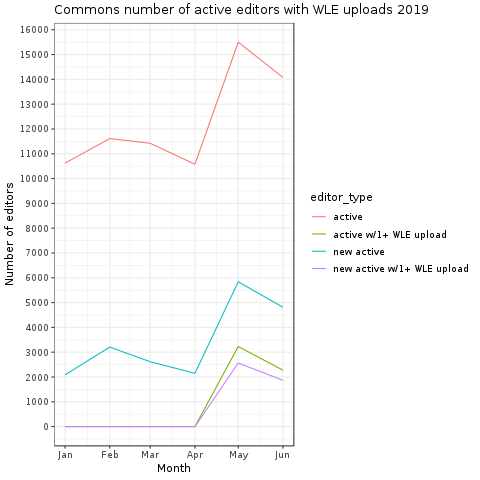

In [122]:
%%R -i commons_wle_overall_stats

commons_wle_overall_stats$log_month = as.Date(commons_wle_overall_stats$log_month)

ggplot(commons_wle_overall_stats,
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_continuous("Number of editors", breaks = c(0:20)*1000) +
scale_x_date("Month") +
ggtitle("Commons number of active editors with WLE uploads 2019") +
geom_line()

In [123]:
## What's the number of new active users w/1+ WLE uploads?

commons_wle_overall_stats.loc[commons_wle_overall_stats.editor_type == 'new active w/1+ WLE upload']

,log_month,editor_type,n
0,2019-01-01,new active w/1+ WLE upload,0
0,2019-02-01,new active w/1+ WLE upload,0
0,2019-03-01,new active w/1+ WLE upload,0
0,2019-04-01,new active w/1+ WLE upload,0
0,2019-05-01,new active w/1+ WLE upload,2564
0,2019-06-01,new active w/1+ WLE upload,1865


In [124]:
## What's the number of WLE uploads per month?

earth_creations.groupby('log_month').count()

,page_id,user_id
log_month,,
2019-05-01,63590,63590
2019-06-01,30826,30826


## Exploration of Commons visualizations

We're interested in illustrating the point about how micro-contributions and Wiki Loves Earth impacts number of active editors on Commons. Thus, we explore some visualizations of that data.

In [213]:
## Some Pandas idioms Neil taught me, thanks Neil!

def micro_wle_stats(group):
    aggs = {
        "neither": len(group.query("num_micros == 0 & earth_edits == 0")),
        "1+ SDC edit": len(group.query("num_micros > 0 & earth_edits == 0")),
        "1+ WLE edit": len(group.query("num_micros == 0 & earth_edits > 0")),
        "both": len(group.query("num_micros > 0 & earth_edits > 0"))
    }
    return pd.Series(aggs, index=aggs.keys())

micro_wle_aggregated = commons_actives_wlep.groupby("log_month").apply(micro_wle_stats)

micro_wle_agg_flat = micro_wle_aggregated.reset_index().melt(id_vars=["log_month"])

Make two graphs:

1. Since January 2019, the number of active editors with 1+ micro-contributions.
2. For May and June 2019, bar charts showing the distribution of micro-contributions and WLE activity.

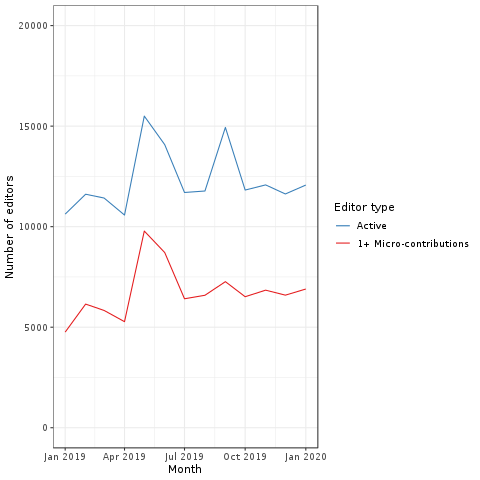

In [174]:
%%R -i commons_active_stats

commons_active_stats = data.table(commons_active_stats)
commons_active_stats[, log_month := as.Date(log_month)]

ggplot(commons_active_stats[log_month >= '2019-01-01' & editor_type %in% c('active', '1+ micro')],
       aes(x = log_month, y = n, colour = editor_type)) +
theme_bw() + 
scale_x_date("Month") +
scale_y_continuous("Number of editors", lim = c(0, 20000)) +
scale_colour_brewer("Editor type", palette = 'Set1',
                    breaks = c("active", "1+ micro"), labels = c("Active", "1+ Micro-contributions")) +
geom_line()

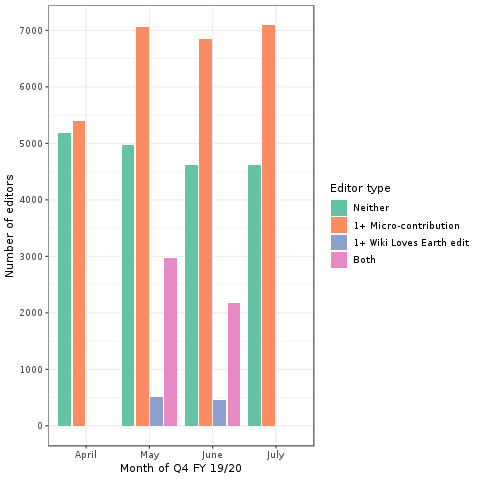

In [127]:
%%R -i micro_wle_agg_flat

micro_wle_agg_flat = data.table(micro_wle_agg_flat)
micro_wle_agg_flat[, log_month := as.Date(log_month)]
micro_wle_agg_flat[, log_year := year(log_month)]
micro_wle_agg_flat[, log_month_name := strftime(log_month, "%B")]
micro_wle_agg_flat[, editor_type := ordered(variable, c("neither", "1+ SDC edit", "1+ WLE edit", "both"))]
micro_wle_agg_flat[, log_month_name := ordered(
    log_month_name,
    c("January", "February", "March", "April", "May", "June",
      "July", "August", "September", "October", "November", "December"))]

g = ggplot(micro_wle_agg_flat[log_month >= '2019-04-01'],
       aes(log_month_name, value, fill = editor_type)) +
theme_bw() + 
scale_y_continuous("Number of editors", breaks = c(0:8)*1000) +
scale_x_discrete("Month of Q4 FY 19/20") +
scale_fill_brewer("Editor type", palette = 'Set2',
                    breaks = c("neither", "1+ SDC edit", "1+ WLE edit", "both"),
                    labels = c("Neither", "1+ Micro-contribution", "1+ Wiki Loves Earth edit", "Both")) +
geom_col(position = "dodge2")

ggsave(plot = g, file = "graphs/commons_active_editors_by_type_Q41819.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

## MC Graph of new and returning active editors on Commons for FY 19/20

Showing users who made at least 1+ micro-contributions, as stacked bar charts.

In [141]:
## Some Pandas idioms Neil taught me, thanks Neil!

def micro_commons_stats(group):
    aggs = {
        "1+ Micro-contributions": len(group.query("num_micros > 0")),
        "0 Micro-contributions": len(group.query("num_micros == 0"))
    }
    return(pd.Series(aggs, index=aggs.keys()))

commons_overall_agg = commons_actives_full.groupby(["log_month", "is_new_active"]).apply(micro_commons_stats)

commons_overall_agg_flat = commons_overall_agg.reset_index().melt(id_vars=["log_month", "is_new_active"])

In [142]:
commons_overall_agg_flat.head()

,log_month,is_new_active,variable,value
0,2018-01-01,0.0,0 Micro-contributions,7471
1,2018-01-01,1.0,0 Micro-contributions,1620
2,2018-02-01,0.0,0 Micro-contributions,7032
3,2018-02-01,1.0,0 Micro-contributions,1407
4,2018-03-01,0.0,0 Micro-contributions,7537


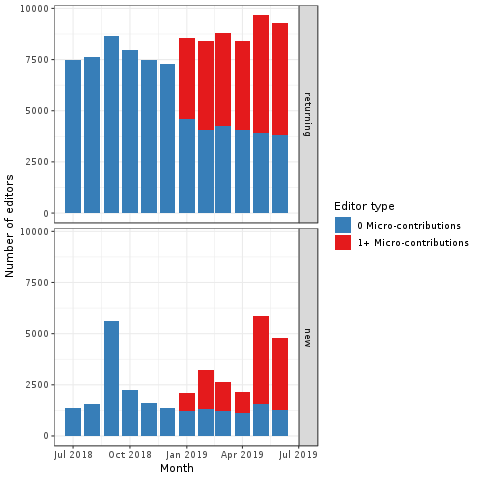

In [244]:
%%R -i commons_overall_agg_flat

commons_overall_agg_flat = data.table(commons_overall_agg_flat)
commons_overall_agg_flat[, log_month := as.Date(log_month)]

commons_overall_agg_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]
commons_overall_agg_flat[, variable := ordered(variable, c("1+ Micro-contributions", "0 Micro-contributions"))]

g = ggplot(commons_overall_agg_flat[log_month >= '2018-07-01' & log_month < '2019-07-01',
                               list(log_month, active_type, editor_type = variable, n = value)],
       aes(x = log_month, y = n, fill = editor_type)) +
theme_bw() +
scale_y_continuous("Number of editors") +
scale_x_date("Month") +
scale_fill_brewer("Editor type", palette = 'Set1', breaks = c("0 Micro-contributions", "1+ Micro-contributions")) + 
facet_grid(active_type ~ .) +
geom_col()

ggsave(plot = g, file = "graphs/commons_active_editors_micros_FY1819_split.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

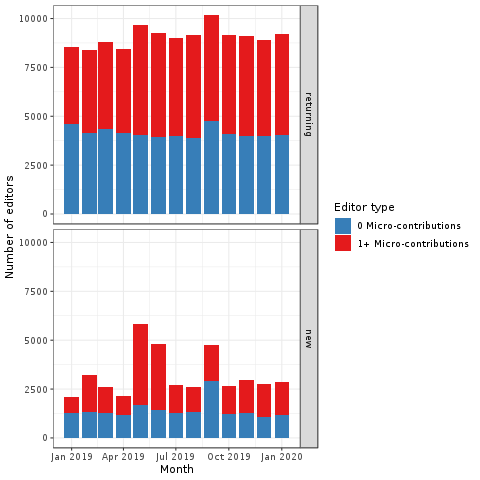

In [183]:
%%R -i commons_overall_agg_flat

commons_overall_agg_flat = data.table(commons_overall_agg_flat)
commons_overall_agg_flat[, log_month := as.Date(log_month)]

commons_overall_agg_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]
commons_overall_agg_flat[, variable := ordered(variable, c("1+ Micro-contributions", "0 Micro-contributions"))]

g = ggplot(commons_overall_agg_flat[log_month >= '2019-01-01' & log_month < '2020-02-01',
                               list(log_month, active_type, editor_type = variable, n = value)],
       aes(x = log_month, y = n, fill = editor_type)) +
theme_bw() +
scale_y_continuous("Number of editors") +
scale_x_date("Month") +
scale_fill_brewer("Editor type", palette = 'Set1', breaks = c("0 Micro-contributions", "1+ Micro-contributions")) + 
facet_grid(active_type ~ .) +
geom_col()

ggsave(plot = g, file = "graphs/commons_active_editors_micros_1920_split.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

As a contrast to the bar chart above, I also made the line chart below.

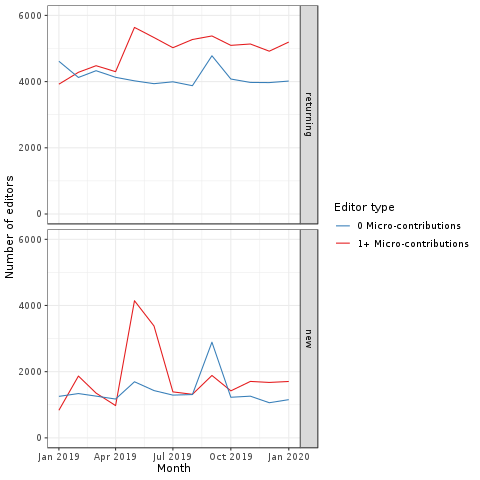

In [56]:
%%R -i commons_overall_agg_flat

commons_overall_agg_flat = data.table(commons_overall_agg_flat)
commons_overall_agg_flat[, log_month := as.Date(log_month)]

commons_overall_agg_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]
commons_overall_agg_flat[, variable := ordered(variable, c("1+ Micro-contributions", "0 Micro-contributions"))]

g = ggplot(commons_overall_agg_flat[log_month >= '2019-01-01' & log_month < '2020-02-01',
                               list(log_month, active_type, editor_type = variable, n = value)],
       aes(x = log_month, y = n, color = editor_type)) +
theme_bw() +
scale_y_continuous("Number of editors", lim = c(0, 6000)) +
scale_x_date("Month") +
scale_color_brewer("Editor type", palette = 'Set1', breaks = c("0 Micro-contributions", "1+ Micro-contributions")) + 
facet_grid(active_type ~ .) +
geom_line()

ggsave(plot = g, file = "graphs/commons_active_editors_micros_1920_split.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

In [197]:
%%R -i commons_overall_agg_flat

commons_overall_agg_flat = data.table(commons_overall_agg_flat)
commons_overall_agg_flat[, log_month := as.Date(log_month)]

commons_overall_agg_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]
commons_overall_agg_flat[, variable := ordered(variable, c("1+ Micro-contributions", "0 Micro-contributions"))]

commons_overall_agg_flat[
        log_month >= '2019-01-01' & log_month < '2020-02-01',
        list(n = sum(value)), by = c('log_month', 'active_type')]

     log_month active_type     n
 1: 2019-01-01   returning  8536
 2: 2019-01-01         new  2088
 3: 2019-02-01   returning  8406
 4: 2019-02-01         new  3207
 5: 2019-03-01   returning  8809
 6: 2019-03-01         new  2615
 7: 2019-04-01   returning  8429
 8: 2019-04-01         new  2148
 9: 2019-05-01   returning  9660
10: 2019-05-01         new  5839
11: 2019-06-01   returning  9268
12: 2019-06-01         new  4810
13: 2019-07-01   returning  9018
14: 2019-07-01         new  2682
15: 2019-08-01   returning  9148
16: 2019-08-01         new  2625
17: 2019-09-01   returning 10159
18: 2019-09-01         new  4777
19: 2019-10-01   returning  9173
20: 2019-10-01         new  2648
21: 2019-11-01   returning  9111
22: 2019-11-01         new  2966
23: 2019-12-01   returning  8889
24: 2019-12-01         new  2737
25: 2020-01-01   returning  9211
26: 2020-01-01         new  2859
     log_month active_type     n


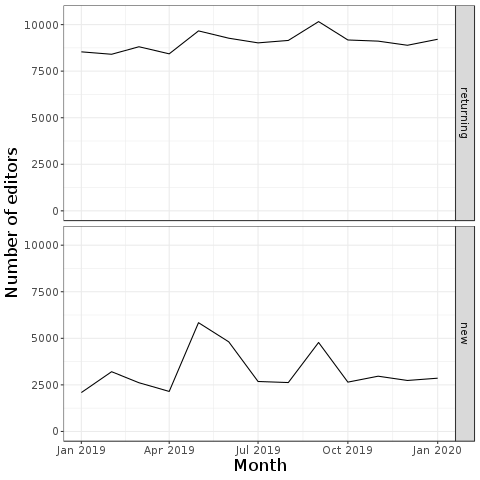

In [275]:
%%R -i commons_overall_agg_flat

commons_overall_agg_flat = data.table(commons_overall_agg_flat)
commons_overall_agg_flat[, log_month := as.Date(log_month)]

commons_overall_agg_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]
commons_overall_agg_flat[, variable := ordered(variable, c("1+ Micro-contributions", "0 Micro-contributions"))]

g = ggplot(
    commons_overall_agg_flat[
        log_month >= '2019-01-01' & log_month < '2020-02-01',
        list(n = sum(value)), by = c('log_month', 'active_type')],
       aes(x = log_month, y = n)) +
    theme_bw() +
    theme(axis.title.x = element_text(size = rel(1.5)),
          axis.text.x = element_text(size = rel(1.25)),
          axis.title.y = element_text(size = rel(1.5)),
          axis.text.y = element_text(size = rel(1.25)),
          strip.text = element_text(size = rel(1))) +
    scale_y_continuous("Number of editors", lim = c(0, 10500)) +
    scale_x_date("Month") +
    facet_grid(active_type ~ .) +
    geom_line()

ggsave(plot = g, file = "graphs/commons_active_editors_1920.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

## WLE graph of new and returning active editors on Commons for FY 19/20

Showing users who made at least 1+ WLE-contributions, as stacked bar charts.

In [158]:
## Some Pandas idioms Neil taught me, thanks Neil!

def wle_commons_stats(group):
    aggs = {
        "1+ WLE-contributions": len(group.query("earth_edits > 0")),
        "0 WLE-contributions": len(group.query("earth_edits == 0"))
    }
    return(pd.Series(aggs, index=aggs.keys()))

commons_wle_agg = commons_actives_wlep.groupby(["log_month", "is_new_active"]).apply(wle_commons_stats)

commons_wle_agg_flat = commons_wle_agg.reset_index().melt(id_vars=["log_month", "is_new_active"])

In [159]:
commons_wle_agg_flat.head()

,log_month,is_new_active,variable,value
0,2018-01-01,0.0,1+ WLE-contributions,0
1,2018-01-01,1.0,1+ WLE-contributions,0
2,2018-02-01,0.0,1+ WLE-contributions,0
3,2018-02-01,1.0,1+ WLE-contributions,0
4,2018-03-01,0.0,1+ WLE-contributions,0


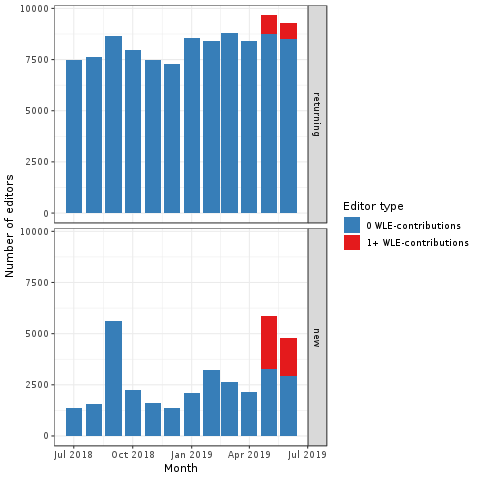

In [243]:
%%R -i commons_wle_agg_flat

commons_wle_agg_flat = data.table(commons_wle_agg_flat)
commons_wle_agg_flat[, log_month := as.Date(log_month)]

commons_wle_agg_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]
commons_wle_agg_flat[, variable := ordered(variable, c("1+ WLE-contributions", "0 WLE-contributions"))]

g = ggplot(commons_wle_agg_flat[log_month >= '2018-07-01' & log_month < '2019-07-01',
                            list(log_month, active_type, editor_type = variable, n = value)],
       aes(x = log_month, y = n, fill = editor_type)) +
theme_bw() +
scale_y_continuous("Number of editors") +
scale_x_date("Month") +
scale_fill_brewer("Editor type", palette = 'Set1', breaks = c("0 WLE-contributions", "1+ WLE-contributions")) +
facet_grid(active_type ~ .) +
geom_col()

ggsave(plot = g, file = "graphs/commons_active_editors_WLE_FY1819_split.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

## MC Graph of new and returning active editors on Wikidata for FY 19/20

Showing users who made at least 1+ micro-contributions, as stacked bar charts.

In [21]:
## Some Pandas idioms Neil taught me, thanks Neil!

def wd_commons_stats(group):
    aggs = {
        "1+ Micro-contributions": len(group.query("num_micros > 0")),
        "0 Micro-contributions": len(group.query("num_micros == 0"))
    }
    return(pd.Series(aggs, index=aggs.keys()))

wikidata_overall_agg = wd_actives_full.groupby(["log_month", "is_new_active"]).apply(wd_commons_stats)

wikidata_overall_agg_flat = wikidata_overall_agg.reset_index().melt(id_vars=["log_month", "is_new_active"])

In [22]:
wikidata_overall_agg_flat.head()

,log_month,is_new_active,variable,value
0,2016-01-01,0.0,0 Micro-contributions,6977
1,2016-01-01,1.0,0 Micro-contributions,395
2,2016-02-01,0.0,0 Micro-contributions,6659
3,2016-02-01,1.0,0 Micro-contributions,403
4,2016-03-01,0.0,0 Micro-contributions,6664


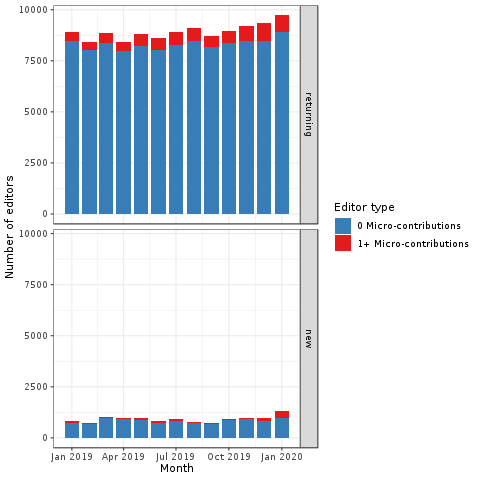

In [23]:
%%R -i wikidata_overall_agg_flat

wikidata_overall_agg_flat = data.table(wikidata_overall_agg_flat)
wikidata_overall_agg_flat[, log_month := as.Date(log_month)]

wikidata_overall_agg_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]
wikidata_overall_agg_flat[, variable := ordered(variable, c("1+ Micro-contributions", "0 Micro-contributions"))]

g = ggplot(wikidata_overall_agg_flat[log_month >= '2019-01-01' & log_month < '2020-02-01',
                               list(log_month, active_type, editor_type = variable, n = value)],
       aes(x = log_month, y = n, fill = editor_type)) +
theme_bw() +
scale_y_continuous("Number of editors") +
scale_x_date("Month") +
scale_fill_brewer("Editor type", palette = 'Set1', breaks = c("0 Micro-contributions", "1+ Micro-contributions")) + 
facet_grid(active_type ~ .) +
geom_col()

ggsave(plot = g, file = "graphs/wikidata_active_editors_micros_1920_split.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

## Categorization of Commons active editors split by new/returning

We repeat the four-way split of active editors we had before, but also facet it by new/returning status.

In [214]:
## Some Pandas idioms Neil taught me, thanks Neil!

def micro_wle_stats(group):
    aggs = {
        "neither": len(group.query("num_micros == 0 & earth_edits == 0")),
        "1+ SDC edit": len(group.query("num_micros > 0 & earth_edits == 0")),
        "1+ WLE edit": len(group.query("num_micros == 0 & earth_edits > 0")),
        "both": len(group.query("num_micros > 0 & earth_edits > 0"))
    }
    return pd.Series(aggs, index=aggs.keys())

micro_wle_aggregated_split = commons_actives_wlep.groupby(["log_month", "is_new_active"]).apply(micro_wle_stats)

micro_wle_agg_split_flat = micro_wle_aggregated_split.reset_index().melt(id_vars=["log_month", "is_new_active"])

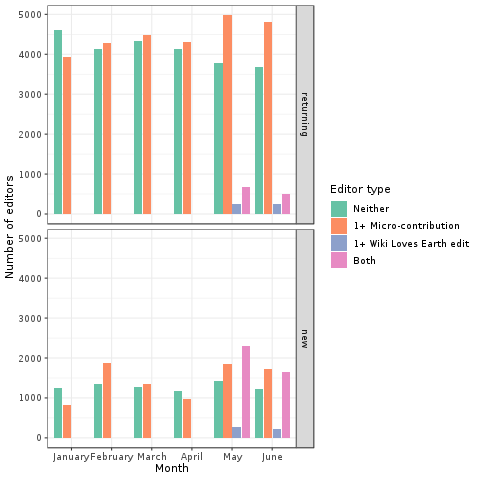

In [215]:
%%R -i micro_wle_agg_split_flat

micro_wle_agg_split_flat = data.table(micro_wle_agg_split_flat)
micro_wle_agg_split_flat[, log_month := as.Date(log_month)]
micro_wle_agg_split_flat[, log_year := year(log_month)]
micro_wle_agg_split_flat[, log_month_name := strftime(log_month, "%B")]
micro_wle_agg_split_flat[, editor_type := ordered(variable, c("neither", "1+ SDC edit", "1+ WLE edit", "both"))]
micro_wle_agg_split_flat[, log_month_name := ordered(
    log_month_name,
    c("January", "February", "March", "April", "May", "June",
      "July", "August", "September", "October", "November", "December"))]

micro_wle_agg_split_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]

g = ggplot(micro_wle_agg_split_flat[log_month >= '2019-01-01' & log_month < '2019-07-01'],
       aes(log_month_name, value, fill = editor_type)) +
theme_bw() + 
scale_y_continuous("Number of editors", breaks = c(0:8)*1000) +
scale_x_discrete("Month") +
scale_fill_brewer("Editor type", palette = 'Set2',
                    breaks = c("neither", "1+ SDC edit", "1+ WLE edit", "both"),
                    labels = c("Neither", "1+ Micro-contribution", "1+ Wiki Loves Earth edit", "Both")) +
geom_col(position = "dodge2") +
facet_grid(active_type ~ .)

ggsave(plot = g, file = "graphs/commons_active_editors_by_type_Q41819_split.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

## Categorization of Wikidata active editors, split by new/returning

We do a similar split as for Commons, but because Wikidata doesn't have WLE, the categorization is "none" (no micro-contributions), "some" (1+ micro-contributions) and "only" (all content edits are micro-contributions).

In [25]:
## Some Pandas idioms Neil taught me, thanks Neil!

def micro_wd_stats(group):
    aggs = {
        "neither": len(group.query("num_micros == 0")),
        "some": len(group.query("num_micros > 0 & num_micros != content_edits")),
        "only": len(group.query("num_micros > 0 & num_micros == content_edits"))
    }
    return pd.Series(aggs, index=aggs.keys())

micro_wd_aggregated_split = wd_actives_full.groupby(["log_month", "is_new_active"]).apply(micro_wd_stats)

micro_wd_aggregated_split_flat = micro_wd_aggregated_split.reset_index().melt(id_vars=["log_month", "is_new_active"])

In [105]:
micro_wd_aggregated_split.head()

neither  only  some
log_month  is_new_active                     
2016-01-01 0.0               6977     0     0
           1.0                395     0     0
2016-02-01 0.0               6659     0     0
           1.0                403     0     0
2016-03-01 0.0               6664     0     0

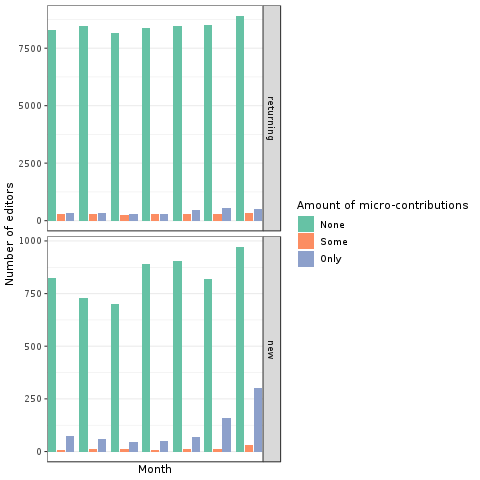

In [182]:
%%R -i micro_wd_aggregated_split_flat

micro_wd_aggregated_split_flat = data.table(micro_wd_aggregated_split_flat)
micro_wd_aggregated_split_flat[, log_month := as.Date(log_month)]
micro_wd_aggregated_split_flat[, editor_type := ordered(variable, c("neither", "some", "only"))]

micro_wd_aggregated_split_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]

g = ggplot(micro_wd_aggregated_split_flat[log_month >= '2019-07-01' & log_month < '2020-02-01'],
       aes(log_month, value, fill = editor_type)) +
theme_bw() + 
scale_y_continuous("Number of editors") +
scale_x_discrete("Month") +
scale_fill_brewer("Amount of micro-contributions", palette = 'Set2',
                    breaks = c("neither", "some", "only"),
                    labels = c("None", "Some", "Only")) +
geom_col(position = "dodge2") +
facet_grid(active_type ~ ., scales = "free")

ggsave(plot = g, file = "graphs/wikidata_active_editors_by_type_FY1819_split.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

This visualization seems to only work when we allow the scales to be free and set by ggplot. Then we can see the scale for new active editors and also notice that the proportion of new active editors making only micro-contributions is higher than the proportion of returning active editors. However, can't that be better visualized by making a time-series plot of that?

In [26]:
micro_wd_aggregated_split = (wd_actives_full.groupby(["log_month", "is_new_active"])
                             .apply(micro_wd_stats).reset_index())

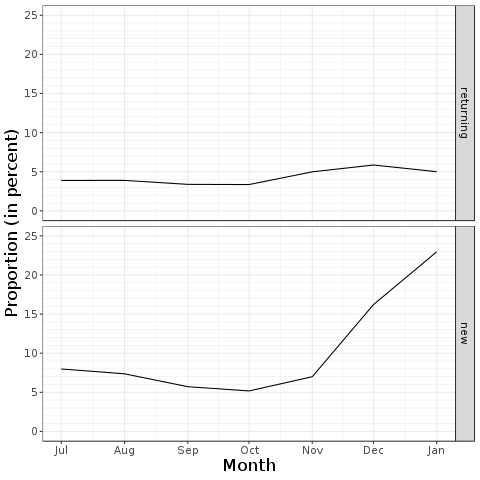

In [276]:
%%R -i micro_wd_aggregated_split

micro_wd_aggregated_split = data.table(micro_wd_aggregated_split)
micro_wd_aggregated_split[, log_month := as.Date(log_month)]

micro_wd_agg = micro_wd_aggregated_split[, list(n_only = only, n_other = some + neither), by = c('log_month', 'is_new_active')]

micro_wd_agg[, prop_only := n_only / (n_only + n_other)]
micro_wd_agg[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]

g = ggplot(micro_wd_agg[log_month >= '2019-07-01' & log_month < '2020-02-01'],
       aes(log_month, 100*prop_only)) +
    theme_bw() + 
    theme(axis.title.x = element_text(size = rel(1.5)),
          axis.text.x = element_text(size = rel(1.25)),
          axis.title.y = element_text(size = rel(1.5)),
          axis.text.y = element_text(size = rel(1.25)),
          strip.text = element_text(size = rel(1))) +
    scale_y_continuous("Proportion (in percent)", limits = c(0, 25), breaks = c(0:5)*5,
                       minor_breaks = c(0:25)) +
    scale_x_date("Month", date_breaks = "1 month", date_labels = "%b") +
    facet_grid(active_type ~ .) +
    geom_line()

ggsave(plot = g, file = "graphs/wikidata_prop_micro_active_editors_FY1920_split.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

In [29]:
%%R
micro_wd_agg[log_month >= "2019-07-01"]

     log_month is_new_active n_only n_other  prop_only active_type
 1: 2019-07-01             0    346    8561 0.03884585   returning
 2: 2019-07-01             1     72     830 0.07982262         new
 3: 2019-08-01             0    354    8751 0.03887974   returning
 4: 2019-08-01             1     59     742 0.07365793         new
 5: 2019-09-01             0    295    8419 0.03385357   returning
 6: 2019-09-01             1     43     709 0.05718085         new
 7: 2019-10-01             0    301    8659 0.03359375   returning
 8: 2019-10-01             1     49     897 0.05179704         new
 9: 2019-11-01             0    460    8759 0.04989695   returning
10: 2019-11-01             1     69     917 0.06997972         new
11: 2019-12-01             0    547    8791 0.05857785   returning
12: 2019-12-01             1    161     832 0.16213494         new
13: 2020-01-01             0    486    9236 0.04998971   returning
14: 2020-01-01             1    300    1006 0.22970904        

## MC Graph of new and returning active editors on Commons for FY 19/20

Showing users who made at least 1+ micro-contributions, as stacked bar charts.

In [30]:
## Some Pandas idioms Neil taught me, thanks Neil!

def micro_commons_stats(group):
    aggs = {
        "1+ Micro-contributions": len(group.query("num_micros > 0")),
        "0 Micro-contributions": len(group.query("num_micros == 0"))
    }
    return(pd.Series(aggs, index=aggs.keys()))

commons_overall_agg = commons_actives_full.groupby(["log_month", "is_new_active"]).apply(micro_commons_stats)

commons_overall_agg_flat = commons_overall_agg.reset_index().melt(id_vars=["log_month", "is_new_active"])

In [31]:
commons_overall_agg_flat.head()

,log_month,is_new_active,variable,value
0,2018-01-01,0.0,0 Micro-contributions,7471
1,2018-01-01,1.0,0 Micro-contributions,1620
2,2018-02-01,0.0,0 Micro-contributions,7032
3,2018-02-01,1.0,0 Micro-contributions,1407
4,2018-03-01,0.0,0 Micro-contributions,7537


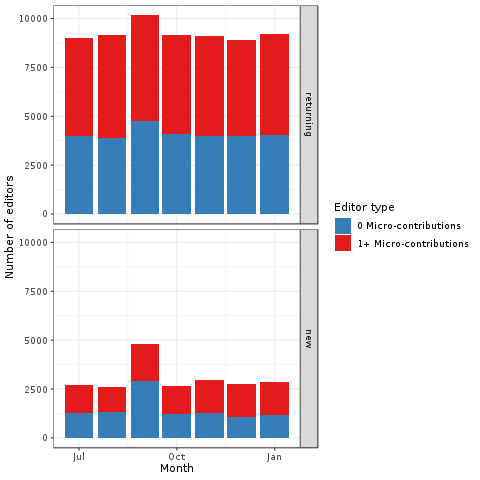

In [32]:
%%R -i commons_overall_agg_flat

commons_overall_agg_flat = data.table(commons_overall_agg_flat)
commons_overall_agg_flat[, log_month := as.Date(log_month)]

commons_overall_agg_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]
commons_overall_agg_flat[, variable := ordered(variable, c("1+ Micro-contributions", "0 Micro-contributions"))]

g = ggplot(commons_overall_agg_flat[log_month >= '2019-07-01' & log_month < '2020-07-01',
                               list(log_month, active_type, editor_type = variable, n = value)],
       aes(x = log_month, y = n, fill = editor_type)) +
theme_bw() +
scale_y_continuous("Number of editors") +
scale_x_date("Month") +
scale_fill_brewer("Editor type", palette = 'Set1', breaks = c("0 Micro-contributions", "1+ Micro-contributions")) + 
facet_grid(active_type ~ .) +
geom_col()

ggsave(plot = g, file = "graphs/commons_active_editors_micros_FY1920_split.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

## Commons active editors with WLM contributions

We repeat the four-way split of active editors we had before, but also facet it by new/returning status.

In [47]:
## Some Pandas idioms Neil taught me, thanks Neil!

def micro_wlm_stats(group):
    aggs = {
        "neither": len(group.query("num_micros == 0 & wlm_edits == 0")),
        "1+ SDC edit": len(group.query("num_micros > 0 & wlm_edits == 0")),
        "1+ WLM edit": len(group.query("num_micros == 0 & wlm_edits > 0")),
        "both": len(group.query("num_micros > 0 & wlm_edits > 0"))
    }
    return pd.Series(aggs, index=aggs.keys())

micro_wlm_aggregated_split = commons_actives_wlm.groupby(["log_month", "is_new_active"]).apply(micro_wlm_stats)

micro_wlm_agg_split_flat = micro_wlm_aggregated_split.reset_index().melt(id_vars=["log_month", "is_new_active"])

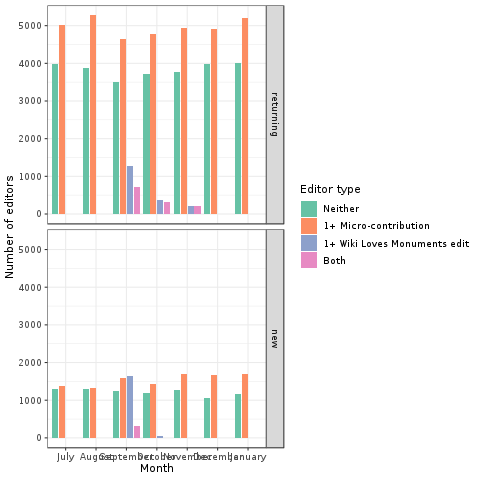

In [48]:
%%R -i micro_wlm_agg_split_flat

micro_wlm_agg_split_flat = data.table(micro_wlm_agg_split_flat)
micro_wlm_agg_split_flat[, log_month := as.Date(log_month)]
micro_wlm_agg_split_flat[, log_year := year(log_month)]
micro_wlm_agg_split_flat[, log_month_name := strftime(log_month, "%B")]
micro_wlm_agg_split_flat[, editor_type := ordered(variable, c("neither", "1+ SDC edit", "1+ WLM edit", "both"))]
micro_wlm_agg_split_flat[, log_month_name := ordered(
    log_month_name,
    c("July", "August", "September", "October", "November", "December",
      "January", "February", "March", "April", "May", "June"))]

micro_wlm_agg_split_flat[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]

g = ggplot(micro_wlm_agg_split_flat[log_month >= '2019-07-01' & log_month < '2020-07-01'],
       aes(log_month_name, value, fill = editor_type)) +
theme_bw() + 
scale_y_continuous("Number of editors", breaks = c(0:8)*1000) +
scale_x_discrete("Month") +
scale_fill_brewer("Editor type", palette = 'Set2',
                    breaks = c("neither", "1+ SDC edit", "1+ WLM edit", "both"),
                    labels = c("Neither", "1+ Micro-contribution", "1+ Wiki Loves Monuments edit", "Both")) +
geom_col(position = "dodge2") +
facet_grid(active_type ~ .)

ggsave(plot = g, file = "graphs/commons_active_editors_by_type_FY1920_split.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

Let's do one better and combine the WLE and WLM data frames, and compare May, June, and September with this split into categories.

In [220]:
micro_wlm_agg_split_flat.loc[micro_wlm_agg_split_flat['log_month'] == '2019-09-01']

,log_month,is_new_active,variable,value
40,2019-09-01,0.0,1+ SDC edit,4652
41,2019-09-01,1.0,1+ SDC edit,1584
90,2019-09-01,0.0,neither,3507
91,2019-09-01,1.0,neither,1257
140,2019-09-01,0.0,both,727
141,2019-09-01,1.0,both,302
190,2019-09-01,0.0,1+ WLM edit,1273
191,2019-09-01,1.0,1+ WLM edit,1634


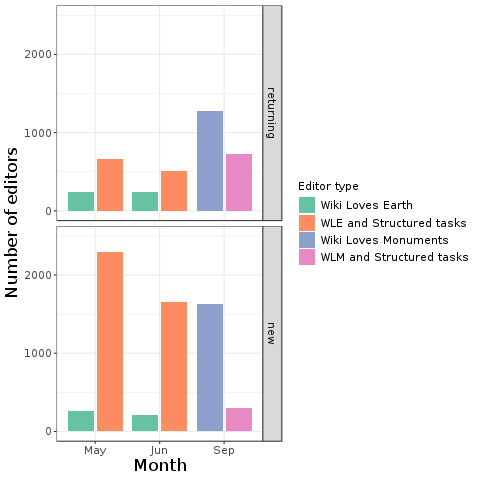

In [279]:
%%R -i micro_wle_agg_split_flat,micro_wlm_agg_split_flat

micro_wlm_agg_split_flat = data.table(micro_wlm_agg_split_flat)
micro_wlm_agg_split_flat[, log_month := as.Date(log_month)]
micro_wlm_agg_split_flat[variable == "both", variable := "WLM and SDC"]

micro_wle_agg_split_flat = data.table(micro_wle_agg_split_flat)
micro_wle_agg_split_flat[, log_month := as.Date(log_month)]
micro_wle_agg_split_flat[variable == "both", variable := "WLE and SDC"]

micro_wlem = rbind(
    micro_wle_agg_split_flat[log_month >= '2019-05-01' & log_month <= '2019-06-01'],
    micro_wlm_agg_split_flat[log_month == '2019-09-01']    
)

## We've taken the "both" category out
micro_wlem[, editor_type := ordered(variable, c("neither", "1+ SDC edit",
                                                "1+ WLE edit", "WLE and SDC",
                                                "1+ WLM edit", "WLM and SDC"
                                               ))]
micro_wlem[, active_type := factor(is_new_active, levels = c(0, 1), labels = c("returning", "new"))]
micro_wlem[, log_year := year(log_month)]
micro_wlem[, log_month_name := strftime(log_month, "%b")]
micro_wlem[, log_month_name := ordered(
    log_month_name,
    c("Jan", "Feb", "Mar", "Apr", "May", "Jun",
      "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"))]

## Might as well take the "neither" and "1+ SDC edit" categories out, because for this
## presentation the focus is on WLE/WLM and SDC specifically.

g = ggplot(micro_wlem[!(editor_type %in% c("neither", "1+ SDC edit"))],
           aes(log_month_name, value, fill = editor_type)) +
    theme_bw() +
    theme(axis.title.x = element_text(size = rel(1.5)),
          axis.text.x = element_text(size = rel(1.25)),
          axis.title.y = element_text(size = rel(1.5)),
          axis.text.y = element_text(size = rel(1.25)),
          strip.text = element_text(size = rel(1)),
          legend.text = element_text(size = rel(1))) +
    scale_x_discrete("Month") +
    scale_y_continuous("Number of editors", limits = c(0, 2500), breaks = c(0:8)*1000) +
    scale_fill_brewer("Editor type", palette = 'Set2',
                        breaks = c("1+ WLE edit", "WLE and SDC", "1+ WLM edit", "WLM and SDC"),
                        labels = c("Wiki Loves Earth",
                                   "WLE and Structured tasks",
                                   "Wiki Loves Monuments",
                                   "WLM and Structured tasks")) +
    geom_col(position = "dodge2") +
    facet_grid(active_type ~ .)

ggsave(plot = g, file = "graphs/commons_WLE_and_WLM_active_editors.png",
       width = 8, height = 6, units = "in", dpi = "retina")
g

## Investigating WLM edit frequency

WLM resulted in a lot of active editors who *didn't* also make SDC-related contributions. What's up with that?

Let's first look at number of SDC and non-SDC edits for users who made at least 1 WLM edit.

In [62]:
(commons_actives_wlm.loc[commons_actives_wlm['wlm_edits'] > 0]
 .groupby('is_new_active')
 .agg({
     'num_micros' : ['mean', 'median'],
     'non_micro_edits' : ['mean', 'median']}
 ))

non_micro_edits        num_micros       
                         mean median       mean median
is_new_active                                         
0.0                943.004836   90.0  92.011928    0.0
1.0                 28.287513   11.0   0.868077    0.0

This is interesting. New active editors with WLM edits made a median of 11 non-SDC edits. That's not a lot, but substantial. But, in both cases the median is 0 SDC edits. I should go investigate that.

In [ ]:
## Grab a random dozen user IDs from users who made WLM edits in Sept 2019, but not any SDC edits
','.join([str(u) for u in
    commons_actives_wlm.loc[
    (commons_actives_wlm['log_month'] == '2019-09-01') &
    (commons_actives_wlm['wlm_edits'] > 0) &
    (commons_actives_wlm['num_micros'] == 0)].sample(12)['user_id']])

In [ ]:
## Grab a random dozen user IDs from users who made WLM edits in Sept 2019, but not any SDC edits
','.join([str(u) for u in
    commons_actives_wlm.loc[
    (commons_actives_wlm['log_month'] == '2019-09-01') &
    (commons_actives_wlm['wlm_edits'] > 0) &
    (commons_actives_wlm['num_micros'] > 0)].sample(12)['user_id']])